In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Uploading the signal data into your code

In [2]:
# source: https://stackoverflow.com/questions/46473270/import-dat-file-as-an-array
def is_float(string):
    """ True if given string is float else False"""
    try:
        return float(string)
    except ValueError:
        return False

data = []
with open('signal.dat', 'r') as f:
    d = f.readlines()
    for i in d:
        k = i.rstrip().split('|')
        for i in k:
            if is_float(i):
                data.append(float(i)) 

data = np.array(data, dtype='float')
time = data[::2]
signal = data[1::2]

In [3]:
# source: https://stackoverflow.com/questions/1730600/principal-component-analysis-in-python
# (observations, features) matrix
M = np.vstack((time, signal))

# singular value decomposition factorises your data matrix such that:
# 
#   M = U*S*V.T     (where '*' is matrix multiplication)
# 
# * U and V are the singular matrices, containing orthogonal vectors of
#   unit length in their rows and columns respectively.
#
# * S is a diagonal matrix containing the singular values of M - these 
#   values squared divided by the number of observations will give the 
#   variance explained by each PC.
#
# * if M is considered to be an (observations, features) matrix, the PCs
#   themselves would correspond to the rows of S^(1/2)*V.T. if M is 
#   (features, observations) then the PCs would be the columns of
#   U*S^(1/2).
#
# * since U and V both contain orthonormal vectors, U*V.T is equivalent 
#   to a whitened version of M.

U, s, Vt = np.linalg.svd(M, full_matrices=False)
V = Vt.T

# PCs are already sorted by descending order 
# of the singular values (i.e. by the
# proportion of total variance they explain)

# if we use all of the PCs we can reconstruct the noisy signal perfectly
S = np.diag(s)
Mhat = np.dot(U, np.dot(S, V.T))
print("Using all PCs, MSE = %.6G" %(np.mean((M - Mhat)**2)))

# if we use only the first 2 PCs the reconstruction is about the same
Mhat2 = np.dot(U[:, :2], np.dot(S[:2, :2], V[:,:2].T))
print("Using first 2 PCs, MSE = %.6G" %(np.mean((M - Mhat2)**2)))

# if we use only the first 1 PCs the reconstruction is less accurate
Mhat1 = np.dot(U[:, :1], np.dot(S[:1, :1], V[:,:1].T))
print("Using first 1 PCs, MSE = %.6G" %(np.mean((M - Mhat1)**2)))


Using all PCs, MSE = 1.5493E-15
Using first 2 PCs, MSE = 1.5493E-15
Using first 1 PCs, MSE = 3.79126


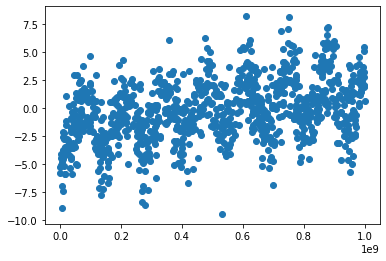

In [4]:
plt.plot(time, signal, 'o')

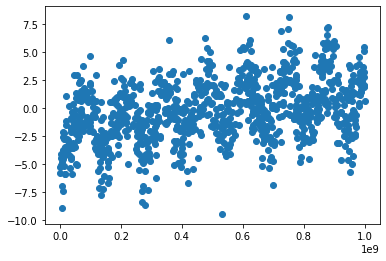

In [5]:
plt.plot(*Mhat2, 'o')

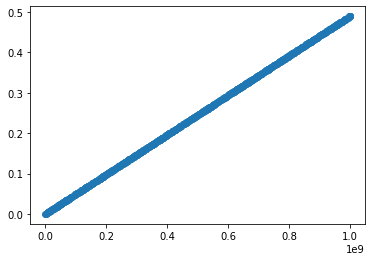

In [6]:
plt.plot(*Mhat1, 'o')

### See Mike's Linear Algebra jupyter notebook on the course website for a tutorial on how to do fitting with SVD

#### Below is an example with an oscillatory signal

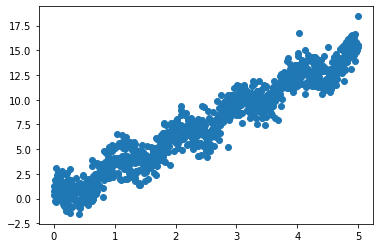

In [7]:
N = 1000
time = np.linspace(0, 5, N)
f_true = 1
omega_true = 2*np.pi*f_true
signal = np.cos(omega_true*time)+np.random.normal(0,1,time.shape)+3*time
plt.plot(time, signal, 'o')

To find the period(s) of the signal's modes, do an FFT and find the dominant frequency
If there is a linear trend, like in the above data, you may want to subtract it off first

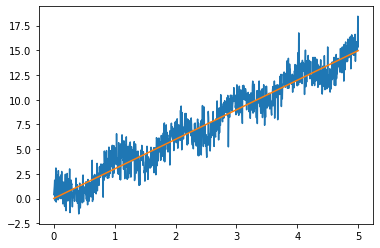

In [8]:
#estimate linear trend
A = np.zeros((len(time), 2))
A[:, 0] = 1.
A[:, 1] = time
(u, w, vt) = np.linalg.svd(A, full_matrices=False)
ainv = vt.transpose().dot(np.diag(1. / w)).dot(u.transpose())
c = ainv.dot(signal)
ym = A.dot(c) 
plt.plot(time, signal)
plt.plot(time, ym)

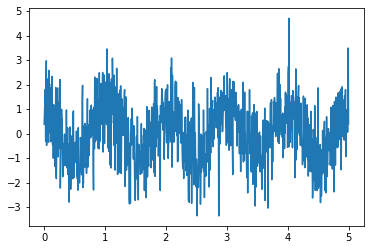

In [9]:
#subtract off linear trend
flat_signal = signal-ym
plt.plot(time, flat_signal)

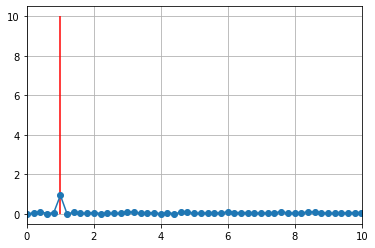

In [10]:
# calculate FFT of oscillations
from scipy.fft import fft, fftfreq
# sample spacing
T = time[1]-time[0]
yf = fft(flat_signal)
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), '-o')
plt.grid()
plt.xlim(0,10)
omega = 2*np.pi*xf[np.argsort(2.0/N * np.abs(yf[0:N//2]))[::-1]][0]
plt.vlines(omega/(2*np.pi), 0, 10, color = 'red')

In [11]:
# fit full signal
A = np.zeros((len(time), 4))
A[:, 0] = 1.
A[:, 1] = time
A[:, 2] = np.cos(omega*time)
A[:, 3] = np.sin(omega*time)


In [12]:
(u, w, vt) = np.linalg.svd(A, full_matrices=False)
ainv = vt.transpose().dot(np.diag(1. / w)).dot(u.transpose())
c = ainv.dot(signal)
ym = A.dot(c) 

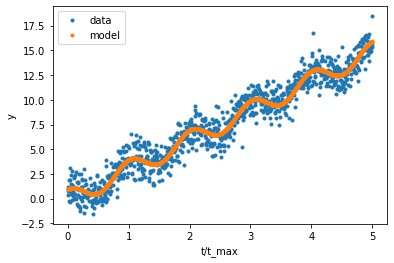

In [13]:
plt.plot(time, signal, '.', label='data')
plt.plot(time, ym, '.', label='model')
plt.xlabel('t/t_max')
plt.ylabel('y')
plt.legend()

### Extra info on fitting:

An excellent introduction to fitting: https://arxiv.org/abs/1008.4686

On board: how to do a fit by hand and get uncertainties in parameters out 

Below: fitting a quadratic

First, write down the log likelihood function:

$\mathcal{L}(m,b) = \sum_{i=1}^{\infty} \ln p(y_i|r_1,r_2, ...;x_i, \sigma_i)$ where $\{r_1, r_2, ...\}$are parameters of the mean model we are fitting to. For a quadratic relationship, we are fitting to the mean model $y = qx^2+mx+b$, so these parameters are $\{q, m, b\}$. 

Then write down the probability of observing data point $y_i$ given the mean model and variance of data point $y_i$:

$p(y_i|...) = \mathcal{N}(y_i|qx^2+mx+b, \sigma_i^2) = \frac{1}{\sqrt{2\pi\sigma_i^2}}e^{-\frac{1}{2\sigma_i^2}\left(y_i-[qx^2+mx+b]\right)^2}$

Then the log of this probability is $\ln p(y_i|...) = -\frac{1}{2\sigma_i^2}(y_i-(qx^2+mx+b))^2 + \ln ...$. We don't care about the constant term because we are going to optimize the log likelihood.

Then the log likelihood is $\mathcal{L} = -\frac{1}{2}\sum_{i=1}^{N}\frac{1}{\sigma_i^2}\left(y_i-[qx^2+mx+b]\right)^2+constant$.

Putting this in matrix form, we get $\mathcal{L} = -\frac{1}{2}(Y-X\theta)^TC^{-1}(Y-X\theta)$.

Maximizing the log likelihood, we get $\hat{\theta} = (X^TC^{-1}X)^{-1}X^TC^{-1}Y$.

Realistically, we want to avoid taking inverses in our code, so we'll solve this form using scipy.linalg.solve:

$(X^TC^{-1}X)\hat{\theta} = X^TC^{-1}Y$

noting that scipy.linalg.solve solves the equation $AZ = B$ for $Z$. Also recall that for the diagonal matrix $C$, $C^{-1}$ is equal to taking the inverse of every element along the diagonal. Remember that diagonal matrices work like numbers in terms of operation rules!

The variance on $\hat{\theta}$ is given by the covariance matrix matrix $C_{\hat{\theta}} = (X^TC^{-1}X)^{-1}$. The diagonal elements are the variance of the q parameter, the linear slope parameter, and the linear intercept parameter, from top to bottom respectively. 

In [14]:
xs = np.array([201, 244, 47, 287, 203, 58, 210, 202, 198, 158, 165, 201, 157, 131, 166, 160, 186, 125, 218, 146])
ys = np.array([592, 401, 583, 402, 495, 173, 479, 504, 510, 416, 393, 442, 317, 311, 400, 337, 423, 334, 533, 344])
sigma_ys = np.array([61, 25, 38, 15, 21, 15, 27, 14, 30, 16, 14, 25, 52, 16, 34, 31, 42, 26, 16, 22])

#select data
data_xs = xs[4:]
data_ys = ys[4:]
data_sigma_ys = sigma_ys[4:]

In [15]:
from scipy import linalg
def quadratic_fit(data_xs, data_ys, data_sigma_ys):
    X = np.vstack((data_xs**2, data_xs, np.ones(len(data_xs)))).T
    Y = np.expand_dims(data_ys, 1)
    C_inv = np.zeros((len(data_xs), len(data_xs)))
    np.fill_diagonal(C_inv, 1/data_sigma_ys**2)
    A = (X.T@C_inv)@X
    B = (X.T@C_inv)@Y

    #solve
    Z = linalg.solve(A, B)

    #fit variance
    A = (X.T@C_inv)@X
    B = np.identity(A.shape[0])
    Z_var = linalg.solve(A, B)
    
    #unpack data
    q = Z[0][0]
    q_err = np.sqrt(Z_var[0][0])  
    m = Z[1][0]
    m_err = np.sqrt(Z_var[1][1])
    b = Z[2][0]
    b_err = np.sqrt(Z_var[2][2]) 
    print(f'The uncertainty variance of the slope line is {m_err**2}')
    return q, q_err, b, b_err, m, m_err

In [16]:
def quadratic(x, q, m, b):
    return q*x**2+m*x+b

In [17]:
q, q_err, b, b_err, m, m_err = quadratic_fit(data_xs, data_ys, data_sigma_ys)

The uncertainty variance of the slope line is 0.33610764206836025


Text(0, 0.5, 'y')

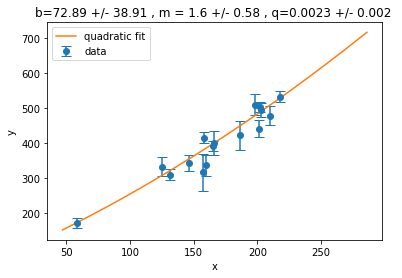

In [18]:
plt.errorbar(data_xs, data_ys, yerr = data_sigma_ys, linestyle = 'None', capsize=5, marker = 'o', label = 'data')
plt.plot(np.arange(np.min(xs), np.max(xs)), quadratic(np.arange(np.min(xs), np.max(xs)), q, m, b), \
         label = 'quadratic fit')
plt.title(f'b={np.around(b,2)} +/- {np.around(b_err,2)} , m = {np.around(m,2)} +/- {np.around(m_err,2)} , q={np.around(q,4)} +/- {np.around(q_err,4)} ')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')